# Additional End of week Exercise - week 2

Now use everything you've learned from Week 2 to build a full prototype for the technical question/answerer you built in Week 1 Exercise.

This should include a Gradio UI, streaming, use of the system prompt to add expertise, and the ability to switch between models. Bonus points if you can demonstrate use of a tool!

If you feel bold, see if you can add audio input so you can talk to it, and have it respond with audio. ChatGPT or Claude can help you, or email me if you have questions.

I will publish a full solution here soon - unless someone beats me to it...

There are so many commercial applications for this, from a language tutor, to a company onboarding solution, to a companion AI to a course (like this one!) I can't wait to see your results.

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


In [5]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [6]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [7]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

In [8]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [9]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [10]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London


In [11]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [12]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

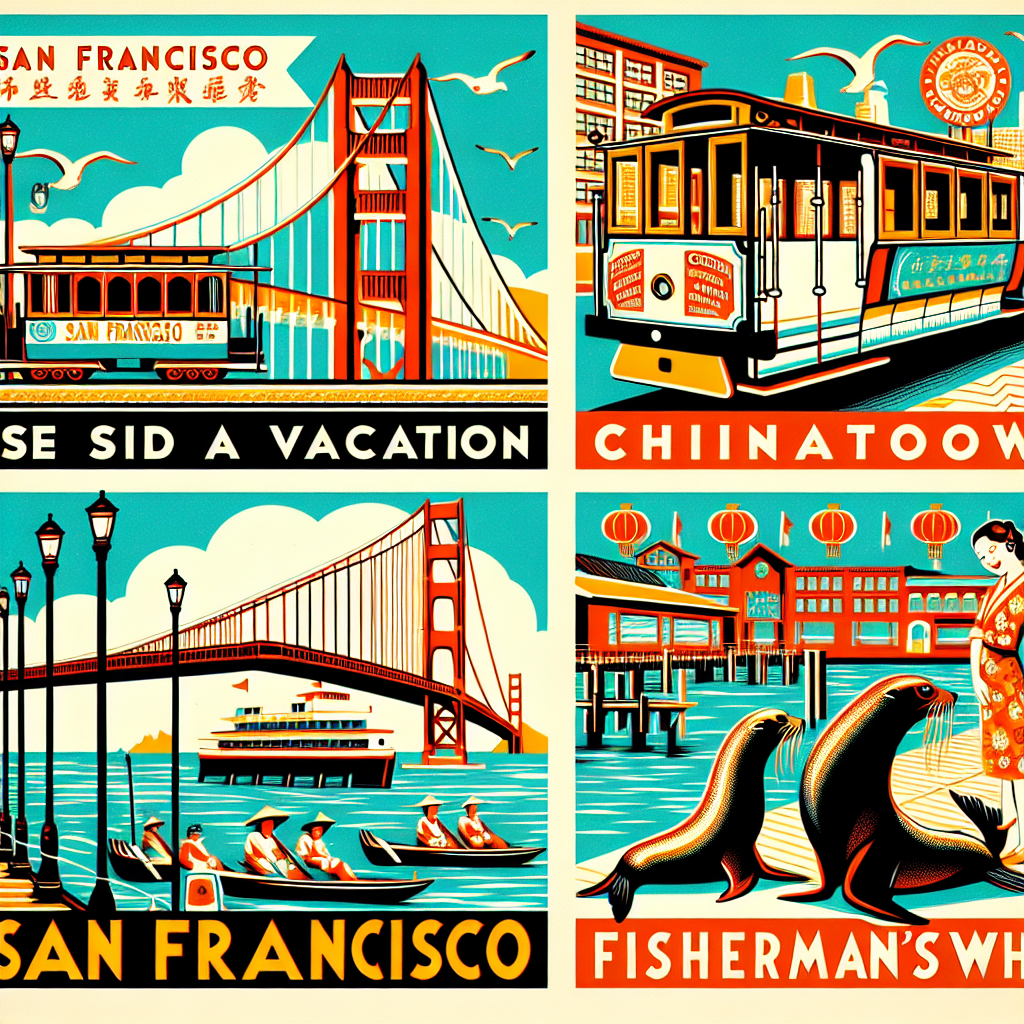

In [13]:
image = artist("San Francisco")
display(image)

In [14]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="alloy",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [26]:
talker("Namaste, trayamwakam yajamahe sugandhim pushtiwardhanam")

Input #0, wav, from '/var/folders/w_/f1q2tn493fng_1vt_6bpj99w0000gp/T/tmpi7ia8wq1.wav':
  Duration: 00:00:03.24, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
   2.99 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B    0.02 M-A: -0.000 fd=   0 aq=  104KB vq=    0KB sq=    0B    0.22 M-A:  0.000 fd=   0 aq=  100KB vq=    0KB sq=    0B    0.43 M-A:  0.000 fd=   0 aq=   92KB vq=    0KB sq=    0B    0.65 M-A:  0.000 fd=   0 aq=   80KB vq=    0KB sq=    0B    0.86 M-A:  0.000 fd=   0 aq=   72KB vq=    0KB sq=    0B    1.09 M-A:  0.000 fd=   0 aq=   60KB vq=    0KB sq=    0B    1.29 M-A:  0.000 fd=   0 aq=   52KB vq=    0KB sq=    0B    1.52 M-A:  0.000 fd=   0 aq=   40KB vq=    0KB sq=    0B    1.75 M-A:  0.000 fd=   0 aq=   28KB vq=    0KB sq=    0B    1.96 M-A:  0.000 fd=   0 aq=   19KB vq=    0KB sq=    0B    2.16 M-A:  0.000 fd=   0 aq=   11KB vq=    0KB sq=    0B    2.39 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=   

   3.12 M-A:  0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B 

In [27]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [28]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


In [54]:
#Assignment -- adding one more tool to book a flight

flight_booking_status = {"london": "booked", "paris": "can't be booked", "tokyo": "pending", "berlin": "payment issue" }

#this is a tool function that will be used by a GPT model

def get_flight_booking_status(destination_city):
    print(f"Tool get_flight_booking_status for {destination_city}")
    city = destination_city.lower()
    return flight_booking_status.get(city, "Unknown")
    

In [55]:
#test the tool 
get_flight_booking_status("berlin")

Tool get_flight_booking_status for berlin


'payment issue'

In [56]:
# Describe metadata about the above tool function so that model can understand it

flight_booking_status_function = {
    "name": "get_flight_booking_status",
    "description": "Get the status to flight booking. Show your answer in polite way, like 'flight booked or cannotn be booked etc...'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to book a flight for",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [34]:
#2 tools - add the above booking status function to the tools list
tools = [{"type": "function", "function": price_function},
         {"type": "function", "function": flight_booking_status_function}]

In [61]:
#update the chat function to use both the tools
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        return response.choices[0].message.content

    if response.choices[1].finish_reason=="tool_calls":
        message = response.choices[1].message
        response, city = handle_flight_status_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)   
        return response.choices[1].message.content


In [62]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7880

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/queueing.py", line 624, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/route_utils.py", line 323, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 2015, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 1560, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/utils.py", line 832, in async_wrapper
    response = await f(*args, **kwargs)
         